# 1. Preparación de datos

## 1.1 Importar librerias

In [17]:
import numpy as np
import cv2
import os
import pandas as pd
from os import listdir
from os.path import join
import sys
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import random
import shutil

## 1.2 Conexiones

#### 1.2.1 Conexión al repositorio en Drive

In [3]:
#Conectar al drive local
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Conectar al repositorio
path = '/content/drive/My Drive/cod/A3_helath'

sys.path.append(path) #Importar las funciones propias a través de import, porque incluye la carpeta del repositorio como uno de esos paquetes para que import busque funciones
os.chdir(path) #Subir y descargar archivos de la ruta del repositorio de trabajo

#### 1.2.2 Importar funciones

In [5]:
%run funciones.ipynb

# 2. Exploración de imágenes

In [6]:
# Rutas de entrenamiento y prueba
train_path = os.path.join(path, 'data/Training')
test_path = os.path.join(path, 'data/Testing')

In [7]:
# Visualización de imágenes ejemplo
img1 = cv2.imread('/content/drive/My Drive/cod/A3_helath/data/Testing/glioma/Te-gl_0010.jpg')
img2 = cv2.imread('/content/drive/My Drive/cod/A3_helath/data/Training/notumor/Tr-no_0010.jpg')
img3 = cv2.imread('/content/drive/My Drive/cod/A3_helath/data/Training/meningioma/Tr-me_0010.jpg')
img4 = cv2.imread('/content/drive/My Drive/cod/A3_helath/data/Training/pituitary/Tr-pi_0010.jpg')

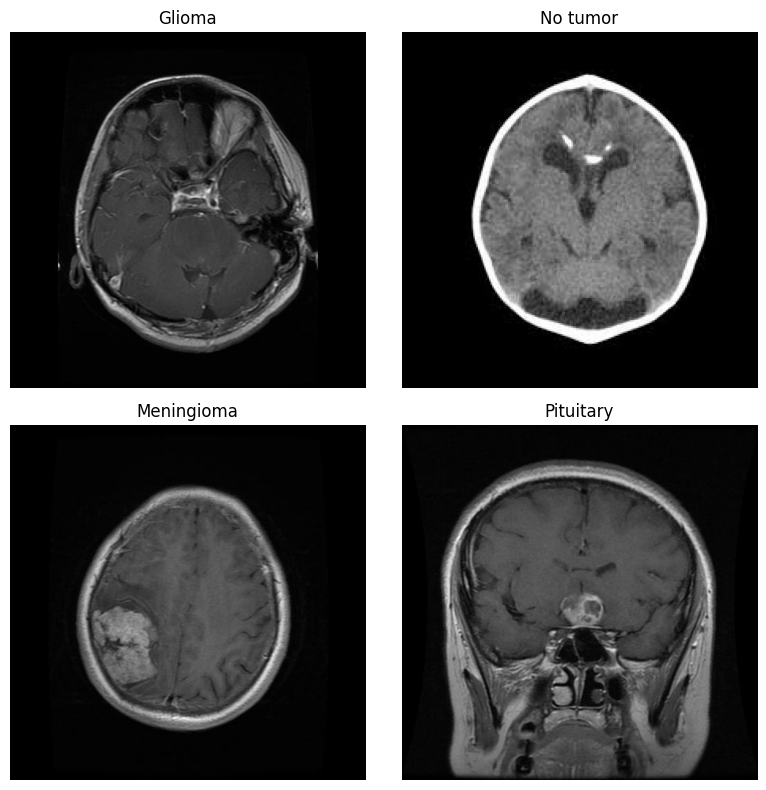

In [8]:
# Convertir de BGR a RGB para que plt las muestre bien
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4_rgb = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

# Mostrar imágenes - Crear una figura con 2 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Ajusta figsize según necesites

# Lista de imágenes y títulos
images = [img1_rgb, img2_rgb, img3_rgb, img4_rgb]
titles = ['Glioma', 'No tumor', 'Meningioma', 'Pituitary']

# Recorrer las imágenes y los ejes para mostrarlas
for ax, img, title in zip(axs.flat, images, titles):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')  # Ocultar los ejes

plt.tight_layout()  # Ajusta los espacios para que no se sobrepongan
plt.show()

In [9]:
# Lista de imágenes y nombres
images = [img1, img2, img3, img4]
names = ['img1', 'img2', 'img3', 'img4']

# Mostrar características numéricas
for name, img in zip(names, images):
    print(f"{name} shape: {img.shape}")
    print(f"{name} max pixel value: {img.max()}")
    print(f"{name} min pixel value: {img.min()}")
    print(f"Total pixels in {name}: {np.prod(img.shape)}")
    print("-" * 40)

img1 shape: (512, 512, 3)
img1 max pixel value: 255
img1 min pixel value: 0
Total pixels in img1: 786432
----------------------------------------
img2 shape: (225, 225, 3)
img2 max pixel value: 255
img2 min pixel value: 0
Total pixels in img2: 151875
----------------------------------------
img3 shape: (512, 512, 3)
img3 max pixel value: 255
img3 min pixel value: 0
Total pixels in img3: 786432
----------------------------------------
img4 shape: (512, 512, 3)
img4 max pixel value: 254
img4 min pixel value: 0
Total pixels in img4: 786432
----------------------------------------


# 3. Definir resolución óptima

In [10]:
# Buscar la imagen con menor resolución entre los dos conjuntos (para evitar perdida de información innecesaria al reescalar)
res_train, img_train = obtener_resolucion_minima(train_path)
res_test, img_test = obtener_resolucion_minima(test_path)

In [11]:
# Elegir la menor resolución (para no generar información al redimensionar)
# Comparar el número total de píxeles entre las resoluciones
area_train = res_train[0] * res_train[1]
area_test = res_test[0] * res_test[1]

# Seleccionar la resolución con menor cantidad de píxeles
if area_train < area_test:
    resolucion_final = res_train
else:
    resolucion_final = res_test

print(f"Resolución seleccionada: {resolucion_final}")

Resolución seleccionada: (150, 198)


Partiendo de la resolución minima del total de imagenes tenemos que esta es de (150,198) pero ademas del tamaño minimo tambien debemos tener en cuenta el ratio (Ancho/Alto) para asegurrar un buen escalado

In [12]:
data_for_df = []
titles =  ['glioma', 'meningioma', 'notumor', 'pituitary']

In [13]:
for folder_name in titles:
    current_folder_path = os.path.join(train_path, folder_name)
    print(f"\nProcesando carpeta: {current_folder_path}")

    promedio_carpeta, std_dev_carpeta, current_ratios, num_images_carpeta = \
        analizar_aspecto_ratio_imagenes(current_folder_path)

    if num_images_carpeta > 0:
        print(f"  Resultados para '{folder_name}':")
        print(f"    Aspecto Ratio Promedio (Ancho/Alto): {promedio_carpeta:.2f}")
        print(f"    Desviación Estándar del Aspecto Ratio: {std_dev_carpeta:.2f}")

        # Almacenar los datos para el DataFrame de pandas
        for ratio in current_ratios:
            data_for_df.append({'categoria': folder_name, 'aspect_ratio': ratio})
    else:
        print(f"  No se procesaron imágenes en '{folder_name}'.")


Procesando carpeta: /content/drive/My Drive/cod/A3_helath/data/Training/glioma
Analizando imágenes en: /content/drive/My Drive/cod/A3_helath/data/Training/glioma
  Resultados para 'glioma':
    Aspecto Ratio Promedio (Ancho/Alto): 1.00
    Desviación Estándar del Aspecto Ratio: 0.00

Procesando carpeta: /content/drive/My Drive/cod/A3_helath/data/Training/notumor
Analizando imágenes en: /content/drive/My Drive/cod/A3_helath/data/Training/notumor
  Resultados para 'notumor':
    Aspecto Ratio Promedio (Ancho/Alto): 0.98
    Desviación Estándar del Aspecto Ratio: 0.20

Procesando carpeta: /content/drive/My Drive/cod/A3_helath/data/Training/meningioma
Analizando imágenes en: /content/drive/My Drive/cod/A3_helath/data/Training/meningioma
  Resultados para 'meningioma':
    Aspecto Ratio Promedio (Ancho/Alto): 0.99
    Desviación Estándar del Aspecto Ratio: 0.05

Procesando carpeta: /content/drive/My Drive/cod/A3_helath/data/Training/pituitary
Analizando imágenes en: /content/drive/My Drive

In [14]:
if data_for_df:
    df_aspect_ratios = pd.DataFrame(data_for_df)
    print("\n--- DataFrame de Aspecto Ratios Creado ---")
    print(f"\nTotal de imágenes con ratios recolectados: {len(df_aspect_ratios)}")

    # --- Cálculo del promedio global de todas las imágenes ---
    global_promedio_ratio = df_aspect_ratios['aspect_ratio'].mean()
    global_std_dev_ratio = df_aspect_ratios['aspect_ratio'].std()

    print("\n--- Análisis de Aspecto Ratio Global (de todas las imágenes) ---")
    print(f"Aspecto Ratio Promedio Global: {global_promedio_ratio:.2f}")
    print(f"Desviación Estándar Global: {global_std_dev_ratio:.2f}")


else:
    print("No se pudieron recolectar ratios de ninguna imagen.")


--- DataFrame de Aspecto Ratios Creado ---

Total de imágenes con ratios recolectados: 5712

--- Análisis de Aspecto Ratio Global (de todas las imágenes) ---
Aspecto Ratio Promedio Global: 0.99
Desviación Estándar Global: 0.11


Con estos resultados debemos buscar una resolución cuya ratio de resolución sea cercano a 1, con lo que partiendo del tamaño minimo de la primera exploración podriamos plantar como tamaño ideal la resolución de 150/151

In [15]:
resolucion_objetivo = 150 / 151
print(f"Aspecto Ratio Objetivo (150/151): {resolucion_objetivo:.2f}")

Aspecto Ratio Objetivo (150/151): 0.99


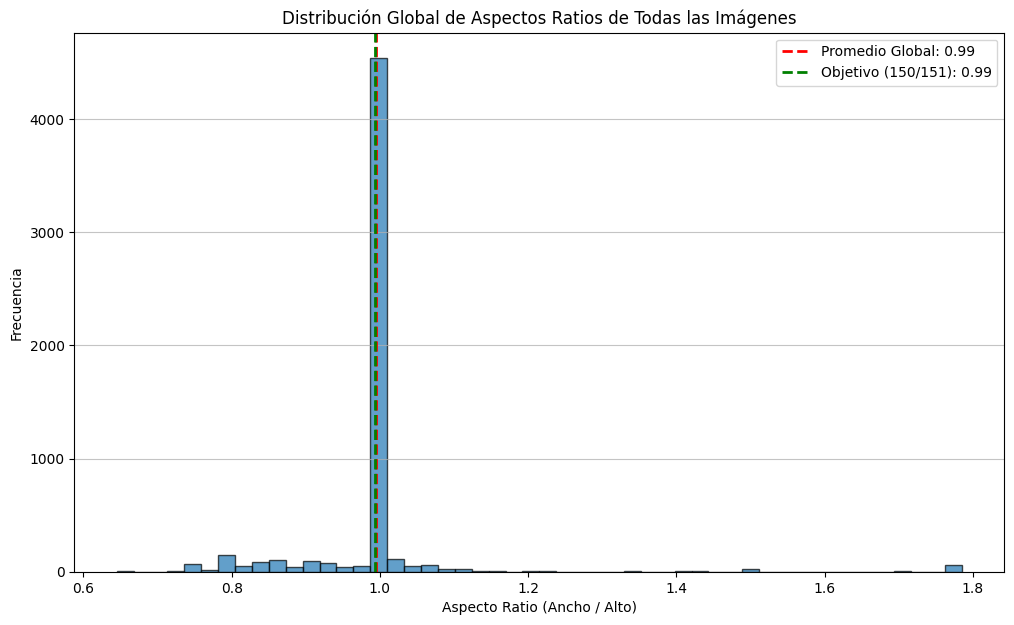


El aspecto ratio promedio global está relativamente cerca del objetivo (150/151). El escalado debería ser manejable.


In [16]:
# --- Visualización del Histograma Global ---
plt.figure(figsize=(12, 7))
plt.hist(df_aspect_ratios['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(global_promedio_ratio, color='red', linestyle='dashed', linewidth=2, label=f'Promedio Global: {global_promedio_ratio:.2f}')
plt.axvline(resolucion_objetivo, color='green', linestyle='dashed', linewidth=2, label=f'Objetivo (150/151): {resolucion_objetivo:.2f}')
plt.title('Distribución Global de Aspectos Ratios de Todas las Imágenes')
plt.xlabel('Aspecto Ratio (Ancho / Alto)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

# Evaluación
if abs(global_promedio_ratio - resolucion_objetivo) < 0.2:
    print("\nEl aspecto ratio promedio global está relativamente cerca del objetivo (150/151). El escalado debería ser manejable.")
else:
    print("\nEl aspecto ratio promedio global difiere significativamente del objetivo (150/151). Considera estrategias de reescalado cuidadosas.")

# 4. Carga de imágenes completas y etiquetas

In [18]:
# Establecer la resolución final como una tupla de enteros
resolucion_final = (150, 151)

# Cargar las imágenes reescaladas con sus etiquetas
x_train, y_train, _ = cargar_imagenes(train_path, tamaño=resolucion_final)
x_test, y_test, _ = cargar_imagenes(test_path, tamaño=resolucion_final)

Cargando pituitary: 100%|██████████| 300/300 [00:03<00:00, 97.41it/s] 


In [19]:
# Convertir a array para entrenamiento
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [20]:
# Ver formas de los datos
print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape: (5712, 151, 150, 3) (5712, 1)
Test shape: (1311, 151, 150, 3) (1311, 1)


In [21]:
# Verificar una muestra
print("Dimensión de una imagen:", x_train[0].shape)
print("Total variables por imagen:", np.prod(x_train[0].shape))

Dimensión de una imagen: (151, 150, 3)
Total variables por imagen: 67950


# 5. Guardar datos procesados

In [22]:
# Crear carpeta si no existe
output_path = os.path.join('data', 'salidas')
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [23]:
# Guardar arrays con Joblib
joblib.dump(x_train, os.path.join(output_path, "x_train.pkl"))
joblib.dump(y_train, os.path.join(output_path, "y_train.pkl"))
joblib.dump(x_test, os.path.join(output_path, "x_test.pkl"))
joblib.dump(y_test, os.path.join(output_path, "y_test.pkl"))

['data/salidas/y_test.pkl']

# 6. Crear muestra para despliegue

In [32]:
# Ruta de guardado
muestra_despliegue_path = '/content/drive/MyDrive/cod/A3_helath/data/data_despliegue'
os.makedirs(muestra_despliegue_path, exist_ok=True)

In [33]:
# Vaciar carpeta si ya tiene archivos
for archivo in os.listdir(muestra_despliegue_path):
    ruta_archivo = os.path.join(muestra_despliegue_path, archivo)
    if os.path.isfile(ruta_archivo):
        os.remove(ruta_archivo)
    elif os.path.isdir(ruta_archivo):
        shutil.rmtree(ruta_archivo)

In [34]:
# Obtener clases únicas
clases = np.unique(y_train)

# Cantidad de imágenes por clase
n_por_clase = 100

# Crear subcarpetas por clase (opcional pero recomendado)
titles =  ['glioma', 'meningioma', 'notumor', 'pituitary']

for clase in clases:
    nombre_clase = titles[int(clase)]
    clase_folder = os.path.join(muestra_despliegue_path, nombre_clase)
    os.makedirs(clase_folder, exist_ok=True)

# Guardar 100 imágenes aleatorias por clase
for clase in clases:
    nombre_clase = titles[int(clase)]
    indices_clase = np.where(y_train == clase)[0]
    indices_muestra = random.sample(list(indices_clase), min(n_por_clase, len(indices_clase)))

    for i, idx in enumerate(indices_muestra):
        imagen = x_train[idx]

        # Guardar imagen en subcarpeta correspondiente
        nombre_archivo = f"{i+1:03d}.jpg"
        ruta_guardado = os.path.join(muestra_despliegue_path, nombre_clase, nombre_archivo)
        cv2.imwrite(ruta_guardado, imagen)

print(f"\n Se guardaron hasta 100 imágenes por cada clase en:\n{muestra_despliegue_path}")


 Se guardaron hasta 100 imágenes por cada clase en:
/content/drive/MyDrive/cod/A3_helath/data/data_despliegue
